In [872]:
import sys; 
sys.path.insert(0, '..')

In [873]:
import findspark
findspark.init()

In [874]:
from pyspark.sql import SparkSession

spark = SparkSession.builder. \
    appName("pyspark-1"). \
    enableHiveSupport(). \
    getOrCreate()

### Read data

In [324]:
import pyspark
import re
import pyspark.sql.functions as pyspfunc
from pyspark.sql.types import DateType,IntegerType#,BooleanType,
import pandas as pd
metadata_metrics = {"num_of_nulls":"",}
#verifying the nulls
df_nulls = df.select([pyspfunc.count(pyspfunc.when(pyspfunc.col(c).isNull(), c)).alias(c) for c in df.columns])
df_nulls = df_nulls.toDF(*hl)
df_nulls = df_nulls.withColumn('metric', pyspfunc.lit("num_of_nulls"))
#calculating max length for each column
df_max_length = df.select([pyspfunc.length(c).alias(c) for c in df.columns]).groupby().max()
df_max_length = df_max_length.toDF(*hl)
df_max_length = df_max_length.withColumn('metric', pyspfunc.lit("max_length"))
#calculating min length for each column
df_min_length = df.select([pyspfunc.length(c).alias(c) for c in df.columns]).groupby().min()
df_min_length = df_min_length.toDF(*hl)
df_min_length = df_min_length.withColumn('metric', pyspfunc.lit("min_length"))
#calculating avg length for each column
df_avg_length = df.select([pyspfunc.length(c).alias(c) for c in df.columns]).groupby().avg()
df_avg_length = df_avg_length.toDF(*hl)
df_avg_length = df_avg_length.withColumn('metric', pyspfunc.lit("min_length"))



df_file_stat = df_nulls.union(df_min_length, df_avg_length, df_max_length)
df_file_stat.printSchema()

df_file_stat = df_file_stat.groupBy(['metric']).max()
hlm = hl[:]
hlm.insert(0,'metric')
print(hlm)
df_file_stat = df_file_stat.toDF(*hlm)
df_file_stat.show(vertical=True)
#df1.groupby().max().show()
#df.select([pyspfunc.count(pyspfunc.when(pyspfunc.isnan(c), c)).alias(c) for c in df.columns]).show(5,truncate=False, vertical=True)
#get the names of the columns as a list
print(df.columns)
#get the number of rows
num_of_rows = df.count()
#get the initial information on every column (exclusion of evidently large text fields)
#analyzed_columns_stg1 = ['job_id', 'agency','posting_type','_of_positions','business_title', 'civil_service_title',
#                        'title_code_no','level','job_category','full_time_part_time_indicator','salary_range_from',
#                        'salary_range_to','salary_frequency','work_location','division_work_unit',
#                        'hours_shift','work_location','recruitment_contact',
#                        'residency_requirement','posting_date','post_until','posting_updated','process_date']
#for c in analyzed_columns_stg1:
#    print(f"""{c} - {df.schema[c].dataType} \
#                  - {len(get_distinct_values(df = df, column = c))}/{num_of_rows} \
#                  - values {get_distinct_values(df = df, column = c)[:3]} \
#                   """)

TypeError: union() takes 2 positional arguments but 4 were given

In [111]:

from pyspark.sql import SQLContext

spark.sql("show databases").show()

spark.sql("DROP TABLE IF EXISTS mytemptable")
df.createOrReplaceTempView("mytempTable")

spark.sql("SELECT count(*) FROM mytempTable").show()

#print(spark.catalog.listTables())
spark.sql("SHOW TABLES").show()

+------------+
|databaseName|
+------------+
|     default|
+------------+

+--------+
|count(1)|
+--------+
|    2946|
+--------+

+--------+-----------+-----------+
|database|  tableName|isTemporary|
+--------+-----------+-----------+
|        |mytemptable|       true|
+--------+-----------+-----------+



### Sample function

In [1179]:
import pyspark
import re
from datetime import datetime
import pyspark.sql.functions as sparkfunc
from pyspark.sql.types import DateType,IntegerType#,BooleanType,
import pandas as pd
from utils.distinct_values import get_distinct_values


#this class is for csv file to be processed with the pyspark

class CSVfiles:
  #initialisation, defining the class  
  def __init__(self, file, path, header, data_type_changes_dict = {}):
    
    self.file = file
    self.path = path
    self.header = header
    self.data_type_changes_dict = data_type_changes_dict
    self.df = spark.read.csv(self.path +'/'+ self.file, header = self.header)
  #method to wrok with the unprocessed csv file (raw data layer)
  def unsparked(self):
    
    df = spark.read.csv(self.path +'/'+ self.file, header = self.header)
    return df
  #method to wrok with the processed csv file (operational and analytical data layers)  
  def sparked(self):
    #putting the csv file data into spark dataframe
    df = self.unsparked()
    #checking if any changes to be performed on data have been passed 
    if self.data_type_changes_dict == {}:
        return df
    else:
        #get the list of column names of the dataframe
        header_list = self.unsparked().columns[:]
        #to fix the names of the headers for pyspark standards (restricted symbols) and change dataset columns format
        for i in range(len(header_list)):
        #get the initial name of the field
            column_name = header_list[i]
        #removes any non-numeric OR non-letter symbol in a column name into underscore and lowers the register
            header_list[i] =  re.sub('[^a-zA-Z0-9] *','_',header_list[i]).lower()
        #roam through the datachange dict to verify if the dataset field needs to have data format changed
            for k,v in self.data_type_changes_dict.items():
                if k in header_list[i].split('_'):
                    #changing the format
                    df = df.withColumn(column_name, sparkfunc.col(column_name).cast(v))
        #renaming the columns of the processed dataset
        df=df.toDF(*header_list)
        #returning the processed dataframe
        return df
  #methods to explore the csv file
  #names of the methods are reflecting the purpose of it
  def column_data_type(self, column_name):
    return str(self.sparked().schema).split(column_name)[1].split(',')[1]

  def num_of_nulls(self, column_name):
    #verifying the nulls
    return self.sparked().filter(sparkfunc.col(column_name).isNull()).count()

  def num_of_records(self, column_name):
    return self.sparked().select(sparkfunc.col(column_name)).count()
 
  def max_length(self, column_name):
    return self.sparked().select(sparkfunc.length(column_name)).groupby().max().collect()[0][0]

  def min_length(self, column_name):
    return self.sparked().select(sparkfunc.length(column_name)).groupby().min().collect()[0][0]
  #min and max values are available for non-string data as it can be quite large
  def max_value(self, column_name):
    if self.column_data_type(column_name) != 'StringType':
        if self.column_data_type(column_name) == 'DateType':
            return self.sparked().select(sparkfunc.max(column_name)).collect()[0][0].strftime("%Y-%m-%d")
        else:
            return self.sparked().select(sparkfunc.max(column_name)).collect()[0][0]
    else:
        return ''

  def min_value(self, column_name):
    if self.column_data_type(column_name) != 'StringType':
        if self.column_data_type(column_name) == 'DateType':
            return self.sparked().select(sparkfunc.max(column_name)).collect()[0][0].strftime("%Y-%m-%d")
        else:
            return self.sparked().select(sparkfunc.min(column_name)).collect()[0][0]
    else:
        return ''
  #using spark built-in function
  def distinct_values_count(self, column_name):
    return len(get_distinct_values(self.sparked(), column_name))
  #method, which uses the class methods to describe the data of the csv file, based on user defined inputs for
  #which fields he/she is interested in and what metrics he/she is interested in for those fields
  def metadata_info(self, metrics_list, columns_list):
        #defining the calss in order to refer to it defined not like an object, but like a string
        workingclass = globals()['CSVfiles'](
                                    file = self.file
                                    ,path = self.path 
                                    ,header = self.header
                                    ,data_type_changes_dict = self.data_type_changes_dict
                                    )
        #the output of this method
        explain_metadata_extended_schema = ["field","metrics"]
        #creating the lambda function dynamically: in accordance to what information user has defined as input parameters 
        def presentation_parameters(structure_schema_list, metrics_list):
            lfunc = 'lambda x: (x.'+ structure_schema_list[0] +','
            lfunc += ' , '.join(['x.' + structure_schema_list[1] + '["' + metrics_list[i] + '"]' for i in range(0, len(metrics_list))])
            lfunc += ')'
            return lfunc
        #defining the output dataframe to be loaded with the calculated data as a list
        explain_metadata_extended = []

        for c in columns_list:           
            column_metric_value_dict_list = [] #defifning the {metric:value} list of dictionaries
            column_metric_value_dict_list.append(c) #appending iterated column name to it
            metric_value_dict = {}#defifning the {metric:value} dictionary
            for m in metrics_list:
                mfunc = getattr(workingclass, m) #calling the class finction, defining is as string via user input
                metric_value_dict[m] = mfunc(c) #adding the metric name and it's calculated value to the dictionary
        
            column_metric_value_dict_list.append(metric_value_dict) #adding all the user defined metrics to be calculated with it's values into the list with the colun name
            explain_metadata_extended.append(tuple(column_metric_value_dict_list)) #append the list as tuple into the list, which will be used as defining the spark dataframe to output
        #forming the spark dataframe
        df = spark.createDataFrame(data=explain_metadata_extended, schema = explain_metadata_extended_schema)
        #forming the structure of the dataframe as per the metrics to be displayed: name of the column is the name of metric
        map_structure = presentation_parameters(explain_metadata_extended_schema, metrics_list)
        #adding the name of the first column in the output dataframe
        metrics_list.insert(0,explain_metadata_extended_schema[0])
        #returning the the datframe with the name of the clumns of the file and the metrics, described it
        return df.rdd.map(eval(map_structure)).toDF(metrics_list)
        
#self.sparked().select([pyspfunc.count(pyspfunc.when(pyspfunc.col(c).isNull(), c)).alias(c) for c in df.columns])
#df_nulls = df_nulls.toDF(*hl)
#df_nulls = df_nulls.withColumn('metric', pyspfunc.lit("num_of_nulls"))
        
  

    
    

In [1180]:
#create a dict where keys are words in header names, which point to datatype of the field - values in the dict
#formats to work with are mentioned in the import section
datachange = {"date":"date","until":"date","updated":"date","id":"int", "range":"int"}
#defining the file, to use created class
f = CSVfiles(
             file = 'nyc-jobs.csv'
             ,path = '/dataset' 
             ,header = True
             ,data_type_changes_dict = datachange
            )
#user-defined columns of the dataset to be assesed with the metrics
columns_to_asses = f.sparked().columns[:]
#defining those metrics, which meed to asses the file
metrics_to_display = ['column_data_type','num_of_records','num_of_nulls','max_length', 'min_length','distinct_values_count', 'min_value', 'max_value']
#calling the method
df2 = f.metadata_info(metrics_to_display, columns_to_asses)
#visualizing as grid (the more fileds and metris - the more time it is taking for calculation)
df2.toPandas()

,field,column_data_type,num_of_records,num_of_nulls,max_length,min_length,distinct_values_count,min_value,max_value
0,job_id,IntegerType,2946,0,6,5,1661,87990,426238
1,agency,StringType,2946,0,30,14,52,,
2,posting_type,StringType,2946,0,8,8,2,,
3,_of_positions,StringType,2946,0,3,1,34,,
4,business_title,StringType,2946,0,117,4,1244,,
5,civil_service_title,StringType,2946,0,30,4,312,,
6,title_code_no,StringType,2946,0,5,4,323,,
7,level,StringType,2946,0,2,1,14,,
8,job_category,StringType,2946,2,201,5,131,,
9,full_time_part_time_indicator,StringType,2946,195,1,1,3,,


In [ ]:
What's the number of jobs posting per category (Top 10)?

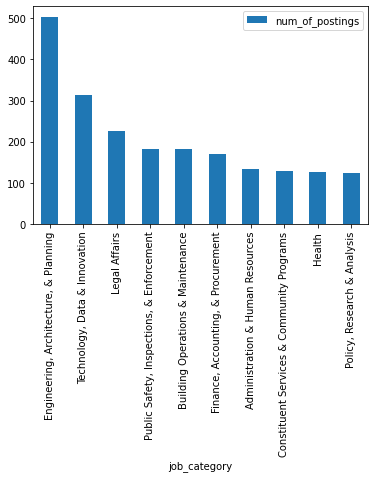

In [1184]:
#job_id is not the unique identifier as a posting can be internal or external

#that is why distinct is not used

#calculating number of postings per each category
ch1 = f.sparked().groupBy("job_category").agg(sparkfunc.count(sparkfunc.col("job_id")).alias("num_of_postings"))
#limiting it to the top 10 (by limiting the output ordered in desc way) and displaying the results as bar chart
ch1.orderBy("num_of_postings", ascending=False).limit(10).toPandas().plot.bar(x = 'job_category', y = 'num_of_postings')


In [ ]:
What's the salary distribution per job category?

In [942]:
# the number of job categories is high, so, it is used as input parameter
#taking the category, having the most number of postings
jc = 'Engineering, Architecture, & Planning'
#defining, which type of salary (there are 2 - minimum and maximun in the fork) to use for the calculation - also input parameter
salary_data_type = 'salary_range_from'
#calculating, how many times the mentioned salary is withing the postings
salary_distribution_stg = f.sparked().filter(sparkfunc.col("job_category")==jc).groupBy("job_category", 
                                                                                       salary_data_type).agg(sparkfunc.count(sparkfunc.col(salary_data_type)). 
                                                                                          alias("salary_distribution"))
#showing the results as grid
salary_distribution_stg.orderBy("salary_distribution", salary_data_type,ascending=False).toPandas()


,job_category,salary_range_from,salary_distribution
0,"Engineering, Architecture, & Planning",55416,38
1,"Engineering, Architecture, & Planning",65783,27
2,"Engineering, Architecture, & Planning",57078,25
3,"Engineering, Architecture, & Planning",78210,22
4,"Engineering, Architecture, & Planning",74990,22
...,...,...,...
73,"Engineering, Architecture, & Planning",37796,2
74,"Engineering, Architecture, & Planning",363,2
75,"Engineering, Architecture, & Planning",45,2
76,"Engineering, Architecture, & Planning",91616,1


In [1034]:
#there are many ways to analyze the distribution
#here:

#per each frequency calculate the min, max and/or average salary

#average salary needs a specific weighted calculation, which is shown in the next challenge

#for this challenge the min_salary is used
ordering_field = "min_salary"
#calculation
ch2 = salary_distribution_stg.groupBy("salary_distribution").agg(sparkfunc.min(sparkfunc.col("salary_range_from")).alias("min_salary"), 
                                             sparkfunc.max(sparkfunc.col("salary_range_from")).alias("max_salary"))
#displaying the calculated data
ch2.orderBy(ordering_field).toPandas()

#number of cases can be recalculated as divided by total number, however,
#for this challenge it won't make a difference


,salary_distribution,min_salary,max_salary
0,2,45,140000
1,1,53,91616
2,4,37217,110000
3,10,48535,57720
4,8,49916,87490
5,14,52137,52137
6,22,53134,78210
7,7,53702,90114
8,38,55416,55416
9,25,57078,57078


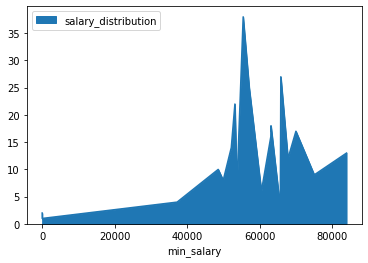

In [1035]:
#displaying the calculation as area graph
ch2.sort(ordering_field).toPandas().plot.area(x = ordering_field, y = "salary_distribution")

In [ ]:
Is there any correlation between the higher degree and the salary?

In [1187]:
from utils.distinct_values import get_distinct_values
#calculating the distinct values of the level column
levels_list = get_distinct_values(df = f.sparked(), column = 'level')
#it is clear, that different agencies are using different gradations of the level
#in order to calculate the correlation thos gradations have to be categorized
#per each gradation category the correlation has to be calculated
#here is a draft of possible categorization, using lambda
categorization = lambda x: "group1" if len(x)==1 else ("group2" if isinstance(x[:1] ,str) else 'group3')
#creating list of categories for the list of levels
levels_list_cat = list(map(categorization, levels_list))
#creating list of tuples with the format (level, category)
categorized_levels = list(map(lambda x,y: tuple([x,y]), levels_list, levels_list_cat))
#making spark dataframe out of it
level_categorization = spark.createDataFrame(data = categorized_levels, schema = ["level_c","category"])
lc = level_categorization
#displaying it as grid
lc.toPandas()

,level_c,category
0,3,group1
1,M4,group2
2,M7,group2
3,4B,group2
4,0,group1
5,M6,group2
6,M1,group2
7,4A,group2
8,M5,group2
9,M2,group2


In [1188]:
#importing component for the windows functions
from pyspark.sql.window import Window
#per each level number of postings with the min/max/avg salary is calculated
#salary for calculation is used from challenge 2
ch2_stg = f.sparked().groupBy("level").agg(sparkfunc.count(sparkfunc.col("job_id")).alias("num_of_postings"),
                                       sparkfunc.min(salary_data_type).alias("min_salary"),
                                       sparkfunc.max(salary_data_type).alias("max_salary"),
                                       sparkfunc.avg(salary_data_type).alias("avg_salary"))

#the number of all postings have to be calcuated within a level categorization
#in order to calculate the weighted statistics for calculation of the estimation
#the average salary used in correlation calculation will be multiplied with the weights

#secondly, as levels are not all integers, the ranking is introduced within each sorted categorized levels group
#as correlation function can only use 2 numeric rows
windowSpec  = Window.partitionBy("category")
windowSpec2  = Window.partitionBy("category").orderBy("level")

ch2_stg3 = ch2_stg.join(lc, ch2_stg["level"] == lc["level_c"],'left') \
            .withColumn("num_of_postings_weighted",sparkfunc.col("num_of_postings")/sparkfunc.sum("num_of_postings").over(windowSpec)) \
            .withColumn("level_new",sparkfunc.rank().over(windowSpec2)) \
            .sort("level")


ch2_stg4 = ch2_stg3.filter(sparkfunc.col("category")=='group1') \
            .withColumn("avg_salary_corrected",sparkfunc.col("avg_salary")*sparkfunc.col("num_of_postings_weighted"))

ch2_stg4.toPandas()


,level,num_of_postings,min_salary,max_salary,avg_salary,level_c,category,num_of_postings_weighted,level_new,avg_salary_corrected
0,0,1112,0,153666,50568.967626,0,group1,0.447665,1,22637.959742
1,1,521,8,85000,45510.243762,1,group1,0.209742,2,9545.425523
2,2,505,0,98388,64100.122772,2,group1,0.203301,3,13031.627214
3,3,299,16,105000,68888.157191,3,group1,0.120370,4,8292.092995
4,4,47,37251,157725,72950.659574,4,group1,0.018921,5,1380.306361


-0.8905448738018039

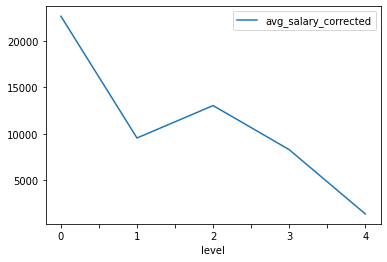

In [1190]:
#calculation of the correlation in between the corrected average salary
#one can say by the coefficient value (89% of the cases) that it's not rejected, that correlation is there
#negative value shows the down trend
ch2_stg4.sort("level").toPandas().plot.line(x = "level", y = "avg_salary_corrected")
ch2_stg4.corr("level_new", "avg_salary_corrected")

0.9092680239990529

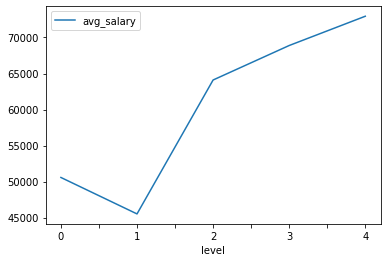

In [1191]:
#calculation of the correlation in between the NOT corrected average salary

#one can say by the coefficient value (90% of the cases) that it's not rejected, that correlation is there
#positive value shows the up trend

#the correction of the average salary by number of observations makes a totqlly opposite difference
ch2_stg4.sort("level").toPandas().plot.line(x = "level", y = "avg_salary")
ch2_stg4.corr("level_new", "avg_salary")

0.7072965779074636

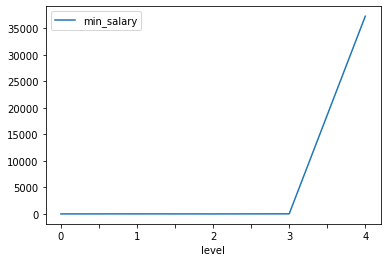

In [1192]:
#calculation of the correlation in between the min salary

#one can say by the coefficient value (70% 0f the cases) that it's not rejected, that correlation is there
#positive value shows the up trend

#in this case more thorough investigation is needed

ch2_stg4.sort("level").toPandas().plot.line(x = "level", y = "min_salary")
ch2_stg4.corr("level_new", "min_salary")

0.13293940115218222

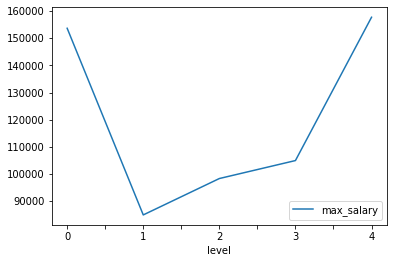

In [1058]:
#calculation of the correlation in between the max salary

#one can say by the coefficient value that it's not accepted, that correlation is there
#the trend is not clear by the graph, though the coefficient is positive

ch2_stg4.sort("level").toPandas().plot.line(x = "level", y = "max_salary")
ch2_stg4.corr("level_new", "max_salary")

In [ ]:
What's the job posting, having the highest salary per agency?

In [1148]:
#salary type is taken as in previous challenge and challenge 2 (salary_data_type)
# window function to calculate the maximun salary across all agency postings 
windowSpec = Window.partitionBy("agency")

ch4_stg = f.sparked() \
            .withColumn("agency_max_salary", sparkfunc.max(salary_data_type).over(windowSpec))
#filtering the postings, having the maximum salary in the agency
ch4 = ch4_stg.filter(sparkfunc.col(salary_data_type) == sparkfunc.col("agency_max_salary"))
ch4.toPandas()


,job_id,agency,posting_type,_of_positions,business_title,civil_service_title,title_code_no,level,job_category,full_time_part_time_indicator,...,to_apply,hours_shift,work_location_1,recruitment_contact,residency_requirement,posting_date,post_until,posting_updated,process_date,agency_max_salary
0,425347,LANDMARKS PRESERVATION COMM,Internal,1,"LANDMARKS PRESERVATIONIST, PRESERVATION DEPT",LANDMARKS PRESERVATIONIST,92237,1,"Engineering, Architecture, & Planning",F,...,national,professional or specialized agencies recogniz...,and one year of full-time satisfactory experi...,None,None,None,None,None,None,55910
1,425347,LANDMARKS PRESERVATION COMM,External,1,"LANDMARKS PRESERVATIONIST, PRESERVATION DEPT",LANDMARKS PRESERVATIONIST,92237,1,"Engineering, Architecture, & Planning",F,...,national,professional or specialized agencies recogniz...,and one year of full-time satisfactory experi...,None,None,None,None,None,None,55910
2,170989,OFFICE OF COLLECTIVE BARGAININ,Internal,1,COLLEGE AIDE - CLERICAL,COLLEGE AIDE (ALL CITY DEPTS),10209,1,Clerical & Administrative Support,P,...,Click the â€œApply Nowâ€ button. While we ap...,Hours: 17 hours per week when school is in se...,None,None,New York City residency is generally required ...,2014-10-09,None,2014-10-16,2019-12-17,8
3,170989,OFFICE OF COLLECTIVE BARGAININ,External,1,COLLEGE AIDE - CLERICAL,COLLEGE AIDE (ALL CITY DEPTS),10209,1,Clerical & Administrative Support,P,...,Click the â€œApply Nowâ€ button. While we ap...,Hours: 17 hours per week when school is in se...,None,None,New York City residency is generally required ...,2014-10-09,None,2014-10-16,2019-12-17,8
4,415570,FIRE DEPARTMENT,Internal,1,Clinical Director for the Couseling Services Unit,ADMINISTRATIVE PSYCHOLOGIST,82980,M2,Health,F,...,all candidates must have the eighteen months ...,managerial,executive or supervisory capacity described i...,"Doctoral degree in Counseling, Clinical Psycho...",None,None,None,None,None,116000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
111,413287,OFF OF PAYROLL ADMINISTRATION,Internal,1,Fiscal Analyst,STAFF ANALYST,12626,2,"Finance, Accounting, & Procurement Policy, Res...",F,...,Current NYC employees may apply to Job ID: 413...,35 Hours Week/Day Shift,"5 Manhattan West, New York, NY",None,New York City residency is generally required ...,2019-09-18,None,2019-11-06,2019-12-17,58152
112,416542,NYC HOUSING AUTHORITY,External,1,Vice-President for Support Services,ADMINISTRATIVE STAFF ANALYST (,10026,M5,"Administration & Human Resources Policy, Resea...",F,...,administrative or supervisory experience,"as described in """"1"""" above.""",None,1.\tDue to the existence of a Civil Service li...,"""Click the """"Apply Now"""" button.""",None,None,None,None,175000
113,416542,NYC HOUSING AUTHORITY,Internal,1,Vice-President for Support Services,ADMINISTRATIVE STAFF ANALYST (,10026,M5,"Administration & Human Resources Policy, Resea...",F,...,administrative or supervisory experience,"as described in """"1"""" above.""",None,1.\tDue to the existence of a Civil Service li...,"""Click the """"Apply Now"""" button.""",None,None,None,None,175000
114,423103,DEPARTMENT OF INVESTIGATION,Internal,1,Deputy Commissioner for Operations,DEPUTY COMMISSIONER,12935,M5,Administration & Human Resources Public Safety...,F,...,individuals and entities that receive City fu...,the Deputy Commissioner for Operations foster...,efficient,and mission-oriented culture that effectively...,including the IT,None,None,None,None,160000


In [ ]:
What's the job postings average salary per agency for the last 2 years?

In [1142]:
from datetime import datetime
from dateutil.relativedelta import relativedelta
#calculating the date, where the last 2 years of data sample starts, based on the data exploration fucntion
diff = datetime.strptime(f.max_value('posting_date'), '%Y-%m-%d') - relativedelta(years=2)
#filtering the data by the date calculated
#grouping by the agency, aggregating by the average salary
ch5_stg = f.sparked().filter(sparkfunc.col("posting_date") > '2019-08-26') \
            .groupBy("agency").agg(sparkfunc.avg(sparkfunc.col(salary_data_type)).alias("avg_salary_2years"))
#showing the data as grid without rounding
ch5_stg.toPandas()

,agency,avg_salary_2years
0,FIRE DEPARTMENT,47113.500000
1,ADMIN FOR CHILDREN'S SVCS,53686.000000
2,TAX COMMISSION,16432.500000
3,HRA/DEPT OF SOCIAL SERVICES,54709.444444
4,TAXI & LIMOUSINE COMMISSION,48616.500000
5,DEPARTMENT OF BUSINESS SERV.,51548.500000
6,DEPT OF DESIGN & CONSTRUCTION,61571.578947
7,TEACHERS RETIREMENT SYSTEM,62397.000000
8,FINANCIAL INFO SVCS AGENCY,81992.600000
9,DEPARTMENT OF CORRECTION,27382.500000


In [ ]:
What are the highest paid skills in the US market?

In [1208]:
#getting the data from challenge 4, where the highest salaried per agency were calculated
#filtering the preferred skills columns for distinct values only
ch6_stg = ch4.select(sparkfunc.col("preferred_skills")).distinct()
#removing all non-letter symbols (not removing blanks)
ch6_stg1 = ch6_stg.withColumn("skills_clean", sparkfunc.regexp_replace(sparkfunc.col("preferred_skills"), "[^a-zA-Z ]", ""))
#making a dataframe of "opened" - exploded - lists of the words from preferrred_skills
#making those distinct and calculating number of times, mentioned within preffered_skills
ch6_stg2 = ch6_stg1.withColumn('skills', sparkfunc.explode(sparkfunc.split(sparkfunc.lower(sparkfunc.col('skills_clean')), ' '))) \
  .distinct() \
  .groupBy('skills') \
  .count()
#filtering out all the words, which length is less than 4 letters
#showing a word from preffered skills with the number of times mentioned
ch6_stg2.filter(sparkfunc.length(sparkfunc.col("skills")) > 4).sort('count', 'skills', ascending=False).limit(50).toPandas()


,skills,count
0,experience,29
1,skills,24
2,strong,20
3,excellent,18
4,ability,18
5,communication,17
6,years,14
7,written,14
8,analytical,14
9,knowledge,12


In [1177]:
from pyspark.sql import SparkSession
from utils.distinct_values import get_distinct_values


def spark_session():
    """Fixture for creating a spark context."""
    return SparkSession.builder. \
        appName("pyspark-test"). \
        getOrCreate()


def test_get_distinct_values():
    spark = spark_session()
    mock_data: list = [('X', 'Annual'), ('Y', 'Daily')]
    expected_result: list = ['Annual', 'Daily']
    schema: list = ['A', 'B']

    mock_df = spark.createDataFrame(data=mock_data, schema=schema)
    assert get_distinct_values(df=mock_df, column='B') == expected_result

In [1178]:
test_get_distinct_values()

In [ ]:
import sys; 
sys.path.insert(0, '..')

import findspark
findspark.init()

from pyspark.sql import SparkSession

spark = SparkSession.builder. \
    appName("pyspark-1"). \
    enableHiveSupport(). \
    getOrCreate()

### Read data

import pyspark
import re
import pyspark.sql.functions as pyspfunc
from pyspark.sql.types import DateType,IntegerType#,BooleanType,
import pandas as pd
metadata_metrics = {"num_of_nulls":"",}
#verifying the nulls
df_nulls = df.select([pyspfunc.count(pyspfunc.when(pyspfunc.col(c).isNull(), c)).alias(c) for c in df.columns])
df_nulls = df_nulls.toDF(*hl)
df_nulls = df_nulls.withColumn('metric', pyspfunc.lit("num_of_nulls"))
#calculating max length for each column
df_max_length = df.select([pyspfunc.length(c).alias(c) for c in df.columns]).groupby().max()
df_max_length = df_max_length.toDF(*hl)
df_max_length = df_max_length.withColumn('metric', pyspfunc.lit("max_length"))
#calculating min length for each column
df_min_length = df.select([pyspfunc.length(c).alias(c) for c in df.columns]).groupby().min()
df_min_length = df_min_length.toDF(*hl)
df_min_length = df_min_length.withColumn('metric', pyspfunc.lit("min_length"))
#calculating avg length for each column
df_avg_length = df.select([pyspfunc.length(c).alias(c) for c in df.columns]).groupby().avg()
df_avg_length = df_avg_length.toDF(*hl)
df_avg_length = df_avg_length.withColumn('metric', pyspfunc.lit("min_length"))



df_file_stat = df_nulls.union(df_min_length, df_avg_length, df_max_length)
df_file_stat.printSchema()

df_file_stat = df_file_stat.groupBy(['metric']).max()
hlm = hl[:]
hlm.insert(0,'metric')
print(hlm)
df_file_stat = df_file_stat.toDF(*hlm)
df_file_stat.show(vertical=True)
#df1.groupby().max().show()
#df.select([pyspfunc.count(pyspfunc.when(pyspfunc.isnan(c), c)).alias(c) for c in df.columns]).show(5,truncate=False, vertical=True)
#get the names of the columns as a list
print(df.columns)
#get the number of rows
num_of_rows = df.count()
#get the initial information on every column (exclusion of evidently large text fields)
#analyzed_columns_stg1 = ['job_id', 'agency','posting_type','_of_positions','business_title', 'civil_service_title',
#                        'title_code_no','level','job_category','full_time_part_time_indicator','salary_range_from',
#                        'salary_range_to','salary_frequency','work_location','division_work_unit',
#                        'hours_shift','work_location','recruitment_contact',
#                        'residency_requirement','posting_date','post_until','posting_updated','process_date']
#for c in analyzed_columns_stg1:
#    print(f"""{c} - {df.schema[c].dataType} \
#                  - {len(get_distinct_values(df = df, column = c))}/{num_of_rows} \
#                  - values {get_distinct_values(df = df, column = c)[:3]} \
#                   """)


from pyspark.sql import SQLContext

spark.sql("show databases").show()

spark.sql("DROP TABLE IF EXISTS mytemptable")
df.createOrReplaceTempView("mytempTable")

spark.sql("SELECT count(*) FROM mytempTable").show()

#print(spark.catalog.listTables())
spark.sql("SHOW TABLES").show()

### Sample function

import pyspark
import re
from datetime import datetime
import pyspark.sql.functions as sparkfunc
from pyspark.sql.types import DateType,IntegerType#,BooleanType,
import pandas as pd
from utils.distinct_values import get_distinct_values


#this class is for csv file to be processed with the pyspark

class CSVfiles:
  #initialisation, defining the class  
  def __init__(self, file, path, header, data_type_changes_dict = {}):
    
    self.file = file
    self.path = path
    self.header = header
    self.data_type_changes_dict = data_type_changes_dict
    self.df = spark.read.csv(self.path +'/'+ self.file, header = self.header)
  #method to wrok with the unprocessed csv file (raw data layer)
  def unsparked(self):
    
    df = spark.read.csv(self.path +'/'+ self.file, header = self.header)
    return df
  #method to wrok with the processed csv file (operational and analytical data layers)  
  def sparked(self):
    #putting the csv file data into spark dataframe
    df = self.unsparked()
    #checking if any changes to be performed on data have been passed 
    if self.data_type_changes_dict == {}:
        return df
    else:
        #get the list of column names of the dataframe
        header_list = self.unsparked().columns[:]
        #to fix the names of the headers for pyspark standards (restricted symbols) and change dataset columns format
        for i in range(len(header_list)):
        #get the initial name of the field
            column_name = header_list[i]
        #removes any non-numeric OR non-letter symbol in a column name into underscore and lowers the register
            header_list[i] =  re.sub('[^a-zA-Z0-9] *','_',header_list[i]).lower()
        #roam through the datachange dict to verify if the dataset field needs to have data format changed
            for k,v in self.data_type_changes_dict.items():
                if k in header_list[i].split('_'):
                    #changing the format
                    df = df.withColumn(column_name, sparkfunc.col(column_name).cast(v))
        #renaming the columns of the processed dataset
        df=df.toDF(*header_list)
        #returning the processed dataframe
        return df
  #methods to explore the csv file
  #names of the methods are reflecting the purpose of it
  def column_data_type(self, column_name):
    return str(self.sparked().schema).split(column_name)[1].split(',')[1]

  def num_of_nulls(self, column_name):
    #verifying the nulls
    return self.sparked().filter(sparkfunc.col(column_name).isNull()).count()

  def num_of_records(self, column_name):
    return self.sparked().select(sparkfunc.col(column_name)).count()
 
  def max_length(self, column_name):
    return self.sparked().select(sparkfunc.length(column_name)).groupby().max().collect()[0][0]

  def min_length(self, column_name):
    return self.sparked().select(sparkfunc.length(column_name)).groupby().min().collect()[0][0]
  #min and max values are available for non-string data as it can be quite large
  def max_value(self, column_name):
    if self.column_data_type(column_name) != 'StringType':
        if self.column_data_type(column_name) == 'DateType':
            return self.sparked().select(sparkfunc.max(column_name)).collect()[0][0].strftime("%Y-%m-%d")
        else:
            return self.sparked().select(sparkfunc.max(column_name)).collect()[0][0]
    else:
        return ''

  def min_value(self, column_name):
    if self.column_data_type(column_name) != 'StringType':
        if self.column_data_type(column_name) == 'DateType':
            return self.sparked().select(sparkfunc.max(column_name)).collect()[0][0].strftime("%Y-%m-%d")
        else:
            return self.sparked().select(sparkfunc.min(column_name)).collect()[0][0]
    else:
        return ''
  #using spark built-in function
  def distinct_values_count(self, column_name):
    return len(get_distinct_values(self.sparked(), column_name))
  #method, which uses the class methods to describe the data of the csv file, based on user defined inputs for
  #which fields he/she is interested in and what metrics he/she is interested in for those fields
  def metadata_info(self, metrics_list, columns_list):
        #defining the calss in order to refer to it defined not like an object, but like a string
        workingclass = globals()['CSVfiles'](
                                    file = self.file
                                    ,path = self.path 
                                    ,header = self.header
                                    ,data_type_changes_dict = self.data_type_changes_dict
                                    )
        #the output of this method
        explain_metadata_extended_schema = ["field","metrics"]
        #creating the lambda function dynamically: in accordance to what information user has defined as input parameters 
        def presentation_parameters(structure_schema_list, metrics_list):
            lfunc = 'lambda x: (x.'+ structure_schema_list[0] +','
            lfunc += ' , '.join(['x.' + structure_schema_list[1] + '["' + metrics_list[i] + '"]' for i in range(0, len(metrics_list))])
            lfunc += ')'
            return lfunc
        #defining the output dataframe to be loaded with the calculated data as a list
        explain_metadata_extended = []

        for c in columns_list:           
            column_metric_value_dict_list = [] #defifning the {metric:value} list of dictionaries
            column_metric_value_dict_list.append(c) #appending iterated column name to it
            metric_value_dict = {}#defifning the {metric:value} dictionary
            for m in metrics_list:
                mfunc = getattr(workingclass, m) #calling the class finction, defining is as string via user input
                metric_value_dict[m] = mfunc(c) #adding the metric name and it's calculated value to the dictionary
        
            column_metric_value_dict_list.append(metric_value_dict) #adding all the user defined metrics to be calculated with it's values into the list with the colun name
            explain_metadata_extended.append(tuple(column_metric_value_dict_list)) #append the list as tuple into the list, which will be used as defining the spark dataframe to output
        #forming the spark dataframe
        df = spark.createDataFrame(data=explain_metadata_extended, schema = explain_metadata_extended_schema)
        #forming the structure of the dataframe as per the metrics to be displayed: name of the column is the name of metric
        map_structure = presentation_parameters(explain_metadata_extended_schema, metrics_list)
        #adding the name of the first column in the output dataframe
        metrics_list.insert(0,explain_metadata_extended_schema[0])
        #returning the the datframe with the name of the clumns of the file and the metrics, described it
        return df.rdd.map(eval(map_structure)).toDF(metrics_list)
        
#self.sparked().select([pyspfunc.count(pyspfunc.when(pyspfunc.col(c).isNull(), c)).alias(c) for c in df.columns])
#df_nulls = df_nulls.toDF(*hl)
#df_nulls = df_nulls.withColumn('metric', pyspfunc.lit("num_of_nulls"))
        
  

    
    

#create a dict where keys are words in header names, which point to datatype of the field - values in the dict
#formats to work with are mentioned in the import section
datachange = {"date":"date","until":"date","updated":"date","id":"int", "range":"int"}
#defining the file, to use created class
f = CSVfiles(
             file = 'nyc-jobs.csv'
             ,path = '/dataset' 
             ,header = True
             ,data_type_changes_dict = datachange
            )
#user-defined columns of the dataset to be assesed with the metrics
columns_to_asses = f.sparked().columns[:]
#defining those metrics, which meed to asses the file
metrics_to_display = ['column_data_type','num_of_records','num_of_nulls','max_length', 'min_length','distinct_values_count', 'min_value', 'max_value']
#calling the method
df2 = f.metadata_info(metrics_to_display, columns_to_asses)
#visualizing as grid (the more fileds and metris - the more time it is taking for calculation)
df2.toPandas()

What's the number of jobs posting per category (Top 10)?

#job_id is not the unique identifier as a posting can be internal or external

#that is why distinct is not used

#calculating number of postings per each category
ch1 = f.sparked().groupBy("job_category").agg(sparkfunc.count(sparkfunc.col("job_id")).alias("num_of_postings"))
#limiting it to the top 10 (by limiting the output ordered in desc way) and displaying the results as bar chart
ch1.orderBy("num_of_postings", ascending=False).limit(10).toPandas().plot.bar(x = 'job_category', y = 'num_of_postings')


What's the salary distribution per job category?

# the number of job categories is high, so, it is used as input parameter
#taking the category, having the most number of postings
jc = 'Engineering, Architecture, & Planning'
#defining, which type of salary (there are 2 - minimum and maximun in the fork) to use for the calculation - also input parameter
salary_data_type = 'salary_range_from'
#calculating, how many times the mentioned salary is withing the postings
salary_distribution_stg = f.sparked().filter(sparkfunc.col("job_category")==jc).groupBy("job_category", 
                                                                                       salary_data_type).agg(sparkfunc.count(sparkfunc.col(salary_data_type)). 
                                                                                          alias("salary_distribution"))
#showing the results as grid
salary_distribution_stg.orderBy("salary_distribution", salary_data_type,ascending=False).toPandas()


#there are many ways to analyze the distribution
#here:

#per each frequency calculate the min, max and/or average salary

#average salary needs a specific weighted calculation, which is shown in the next challenge

#for this challenge the min_salary is used
ordering_field = "min_salary"
#calculation
ch2 = salary_distribution_stg.groupBy("salary_distribution").agg(sparkfunc.min(sparkfunc.col("salary_range_from")).alias("min_salary"), 
                                             sparkfunc.max(sparkfunc.col("salary_range_from")).alias("max_salary"))
#displaying the calculated data
ch2.orderBy(ordering_field).toPandas()

#number of cases can be recalculated as divided by total number, however,
#for this challenge it won't make a difference


#displaying the calculation as area graph
ch2.sort(ordering_field).toPandas().plot.area(x = ordering_field, y = "salary_distribution")

Is there any correlation between the higher degree and the salary?

from utils.distinct_values import get_distinct_values
#calculating the distinct values of the level column
levels_list = get_distinct_values(df = f.sparked(), column = 'level')
#it is clear, that different agencies are using different gradations of the level
#in order to calculate the correlation thos gradations have to be categorized
#per each gradation category the correlation has to be calculated
#here is a draft of possible categorization, using lambda
categorization = lambda x: "group1" if len(x)==1 else ("group2" if isinstance(x[:1] ,str) else 'group3')
#creating list of categories for the list of levels
levels_list_cat = list(map(categorization, levels_list))
#creating list of tuples with the format (level, category)
categorized_levels = list(map(lambda x,y: tuple([x,y]), levels_list, levels_list_cat))
#making spark dataframe out of it
level_categorization = spark.createDataFrame(data = categorized_levels, schema = ["level_c","category"])
lc = level_categorization
#displaying it as grid
lc.toPandas()

#importing component for the windows functions
from pyspark.sql.window import Window
#per each level number of postings with the min/max/avg salary is calculated
#salary for calculation is used from challenge 2
ch2_stg = f.sparked().groupBy("level").agg(sparkfunc.count(sparkfunc.col("job_id")).alias("num_of_postings"),
                                       sparkfunc.min(salary_data_type).alias("min_salary"),
                                       sparkfunc.max(salary_data_type).alias("max_salary"),
                                       sparkfunc.avg(salary_data_type).alias("avg_salary"))

#the number of all postings have to be calcuated within a level categorization
#in order to calculate the weighted statistics for calculation of the estimation
#the average salary used in correlation calculation will be multiplied with the weights

#secondly, as levels are not all integers, the ranking is introduced within each sorted categorized levels group
#as correlation function can only use 2 numeric rows
windowSpec  = Window.partitionBy("category")
windowSpec2  = Window.partitionBy("category").orderBy("level")

ch2_stg3 = ch2_stg.join(lc, ch2_stg["level"] == lc["level_c"],'left') \
            .withColumn("num_of_postings_weighted",sparkfunc.col("num_of_postings")/sparkfunc.sum("num_of_postings").over(windowSpec)) \
            .withColumn("level_new",sparkfunc.rank().over(windowSpec2)) \
            .sort("level")


ch2_stg4 = ch2_stg3.filter(sparkfunc.col("category")=='group1') \
            .withColumn("avg_salary_corrected",sparkfunc.col("avg_salary")*sparkfunc.col("num_of_postings_weighted"))

ch2_stg4.toPandas()


#calculation of the correlation in between the corrected average salary
#one can say by the coefficient value (89% of the cases) that it's not rejected, that correlation is there
#negative value shows the down trend
ch2_stg4.sort("level").toPandas().plot.line(x = "level", y = "avg_salary_corrected")
ch2_stg4.corr("level_new", "avg_salary_corrected")

#calculation of the correlation in between the NOT corrected average salary

#one can say by the coefficient value (90% of the cases) that it's not rejected, that correlation is there
#positive value shows the up trend

#the correction of the average salary by number of observations makes a totqlly opposite difference
ch2_stg4.sort("level").toPandas().plot.line(x = "level", y = "avg_salary")
ch2_stg4.corr("level_new", "avg_salary")

#calculation of the correlation in between the min salary

#one can say by the coefficient value (70% 0f the cases) that it's not rejected, that correlation is there
#positive value shows the up trend

#in this case more thorough investigation is needed

ch2_stg4.sort("level").toPandas().plot.line(x = "level", y = "min_salary")
ch2_stg4.corr("level_new", "min_salary")

#calculation of the correlation in between the max salary

#one can say by the coefficient value that it's not accepted, that correlation is there
#the trend is not clear by the graph, though the coefficient is positive

ch2_stg4.sort("level").toPandas().plot.line(x = "level", y = "max_salary")
ch2_stg4.corr("level_new", "max_salary")

What's the job posting, having the highest salary per agency?

#salary type is taken as in previous challenge and challenge 2 (salary_data_type)
# window function to calculate the maximun salary across all agency postings 
windowSpec = Window.partitionBy("agency")

ch4_stg = f.sparked() \
            .withColumn("agency_max_salary", sparkfunc.max(salary_data_type).over(windowSpec))
#filtering the postings, having the maximum salary in the agency
ch4 = ch4_stg.filter(sparkfunc.col(salary_data_type) == sparkfunc.col("agency_max_salary"))
ch4.toPandas()


What's the job postings average salary per agency for the last 2 years?

from datetime import datetime
from dateutil.relativedelta import relativedelta
#calculating the date, where the last 2 years of data sample starts, based on the data exploration fucntion
diff = datetime.strptime(f.max_value('posting_date'), '%Y-%m-%d') - relativedelta(years=2)
#filtering the data by the date calculated
#grouping by the agency, aggregating by the average salary
ch5_stg = f.sparked().filter(sparkfunc.col("posting_date") > '2019-08-26') \
            .groupBy("agency").agg(sparkfunc.avg(sparkfunc.col(salary_data_type)).alias("avg_salary_2years"))
#showing the data as grid without rounding
ch5_stg.toPandas()

What are the highest paid skills in the US market?

#getting the data from challenge 4, where the highest salaried per agency were calculated
#filtering the preferred skills columns for distinct values only
ch6_stg = ch4.select(sparkfunc.col("preferred_skills")).distinct()
#removing all non-letter symbols (not removing blanks)
ch6_stg1 = ch6_stg.withColumn("skills_clean", sparkfunc.regexp_replace(sparkfunc.col("preferred_skills"), "[^a-zA-Z ]", ""))
#making a dataframe of "opened" - exploded - lists of the words from preferrred_skills
#making those distinct and calculating number of times, mentioned within preffered_skills
ch6_stg2 = ch6_stg1.withColumn('skills', sparkfunc.explode(sparkfunc.split(sparkfunc.lower(sparkfunc.col('skills_clean')), ' '))) \
  .distinct() \
  .groupBy('skills') \
  .count()
#filtering out all the words, which length is less than 4 letters
#showing a word from preffered skills with the number of times mentioned
ch6_stg2.filter(sparkfunc.length(sparkfunc.col("skills")) > 4).sort('count', 'skills', ascending=False).limit(50).toPandas()


from pyspark.sql import SparkSession
from utils.distinct_values import get_distinct_values


def spark_session():
    """Fixture for creating a spark context."""
    return SparkSession.builder. \
        appName("pyspark-test"). \
        getOrCreate()


def test_get_distinct_values():
    spark = spark_session()
    mock_data: list = [('X', 'Annual'), ('Y', 'Daily')]
    expected_result: list = ['Annual', 'Daily']
    schema: list = ['A', 'B']

    mock_df = spark.createDataFrame(data=mock_data, schema=schema)
    assert get_distinct_values(df=mock_df, column='B') == expected_result

test_get_distinct_values()